In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fast_borf import BorfBuilder
from fast_borf.pipeline.zero_columns_remover import ZeroColumnsRemover
from fast_borf.pipeline.reshaper import ReshapeTo2D
from fast_borf.pipeline.to_scipy import ToScipySparse
from fast_borf.xai.mapping import BagOfReceptiveFields
from downtime import load_dataset
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import FunctionTransformer
from shap import LinearExplainer
from matplotlib.colors import CenteredNorm
from scipy.spatial.distance import cdist
from matplotlib.collections import LineCollection
import matplotlib.ticker as ticker
import matplotlib

/Users/francesco/miniforge3/envs/borf_numba/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
X_train, y_train, X_test, y_test = load_dataset("CBF")()

In [4]:
pipe = make_pipeline(BorfBuilder(
    min_window_to_signal_std_ratio=0.15,
    pipeline_objects=[
        (ReshapeTo2D, dict(keep_unraveled_index=True)),
        (ZeroColumnsRemover, dict(axis=0)),
        (ToScipySparse, dict()),
        ],
).build(X_train), FunctionTransformer(np.arcsinh),
                     RidgeClassifierCV())

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

1.0

In [7]:
borf = pipe[0]
mapper = BagOfReceptiveFields(borf)
print(len(mapper.mapping))

12925


In [8]:
n = 100
mapper.build(np.array(X_train)[:n], y_train[:n], pipe.predict(X_train[:n]))

/Users/francesco/github/borf/fast_borf/xai/sax_mapping.py:51: NumbaTypeSafetyWarning: unsafe cast from int64 to uint64. Precision may be lost.
  if word_int not in sax_conversion:


In [9]:
X_tr_n = borf.transform(np.array(X_train)[:n])
exp = LinearExplainer(pipe[-1], X_tr_n)

In [17]:
F = exp.shap_values(X_tr_n).swapaxes(1, 2).swapaxes(0, 1)  # (n_classes, n_samples, n_features)

In [19]:
mapper.add_feature_importance(F)
mapper.map_contained_feature_importance_to_saliency(count_overlapping=False)
mapper.map_notcontained_feature_importance()

/Users/francesco/github/borf/fast_borf/xai/mapping.py:159: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  F_single_norm = self.map_single_notcontained_feature_importance(i)


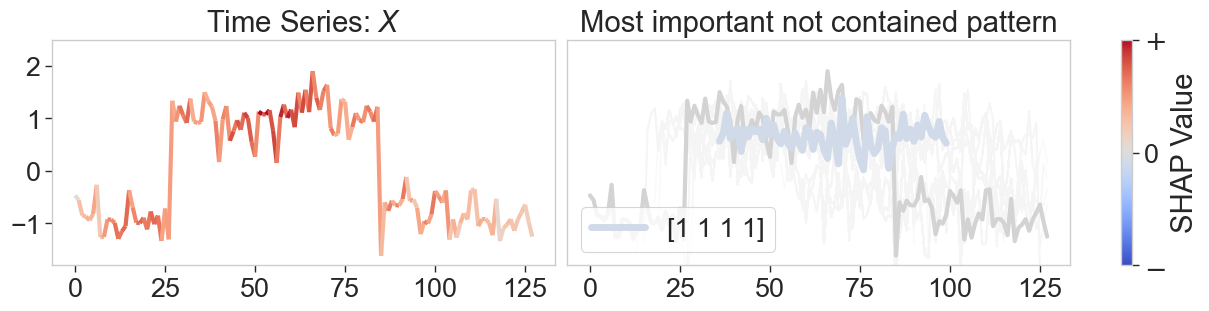

In [26]:
i = 0

sns.set_context("paper", font_scale=2.2)

y_true = mapper.y_true_[i]
y_pred = mapper.y_pred_[i]
x_tr = mapper.X_transformed_[i].toarray()
f_norm = mapper.F_norm_[i]
signal_idxs = mapper.mapping[:, 1]
zero_indices = np.argwhere(x_tr == 0)[:, 1]
num_signals = np.max(signal_idxs) + 1
sorted_indices_by_signal = []

for signal in range(num_signals):
    signal_indices = zero_indices[signal_idxs[zero_indices] == signal]
    
    if len(signal_indices) > 0:
        filtered_importance = f_norm[signal_indices]
        abs_importance = np.abs(filtered_importance)
        sorted_indices = np.argsort(-abs_importance)
        sorted_original_indices = signal_indices[sorted_indices]
        sorted_indices_by_signal.append(sorted_original_indices)
    
    else:
        sorted_indices_by_signal.append(np.array([]))

all_values = np.concatenate([mapper.S_[i].ravel(), f_norm[~np.isnan(f_norm)]])

cmap = plt.get_cmap('coolwarm')
norm = CenteredNorm()
norm(all_values)
fig, axs = plt.subplots(len(mapper.X_[0]), 2, figsize=(12, num_signals*3), width_ratios=[1, 1], sharey=True, sharex=True, squeeze=False, layout="constrained")

for j in range(len(mapper.X_[0])):
    x = mapper.X_[i, j]
    s = mapper.S_[i, j]
    y_true = mapper.y_true_[i]
    y_pred = mapper.y_pred_[i]
    x_tr = mapper.X_transformed_[i].toarray()
    line_colors = cmap(norm(s.ravel()))
    points = np.array([np.arange(0, len(x)), (x-x.mean())/x.std()]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm, lw=3)
    lc.set_array(s)
    axs[j, 0].add_collection(lc)
    axs[j, 0].autoscale()
    axs[j, 0].grid(False)
    axs[j, 0].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
    axs[j, 0].yaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[j, 0].set_title(r"Time Series: $X$")
    
    rfield = mapper.receptive_fields_[sorted_indices_by_signal[j][0]]
    rfields = np.vstack(rfield.mappings)
    rfields = rfields.reshape(rfields.shape[0], -1)
    rfields_idxs = np.vstack(rfield.alignments)
    rfields_idxs = rfields_idxs.reshape(rfields.shape[0], -1)
    rfields_idx = rfield.plot_idx
    rfields_mean = rfields.mean(axis=1)
    rfields_std = rfields.std(axis=1)
    avg_starting_idx = np.floor(np.median(np.vstack(rfield.alignments)[:, 0, 0])).astype(int)
    min_idx = np.min(np.vstack(rfield.alignments))
    max_idx = np.max(np.vstack(rfield.alignments))
    rfields_norm = (rfields - rfields_mean[:, np.newaxis]) / (rfields_std[:, np.newaxis] + 1e-6) * ((x-x.mean())/x.std())[avg_starting_idx + rfields_idx].std() + ((x-x.mean())/x.std())[avg_starting_idx + rfields_idx].mean()
    rfields_norm = rfields
    rfield_importance = rfield.feature_importance_norm[i]
    rfield_centroid = rfields_norm.mean(axis=0)
    rfield_qt5 = np.median(rfields_norm, axis=0)
    rfield_qt25 = np.percentile(rfields_norm, 25, axis=0)
    rfield_qt75 = np.percentile(rfields_norm, 75, axis=0)
    
    distances = cdist(rfields_norm, rfields_norm, metric='euclidean')
    medoid_index = np.argmin(distances.sum(axis=0))
    rfield_medoid = rfields_norm[medoid_index]
    axs[j, 1].plot(rfields_idxs.T, rfields_norm.T, c="whitesmoke", alpha=0.5, zorder=0)
    axs[j, 1].set_title(f"Most important not contained pattern")
    axs[j, 1].plot((x-x.mean())/x.std(), c='lightgray', lw=3)
    axs[j, 1].plot(avg_starting_idx + rfields_idx, rfield_medoid, c=cmap(norm(rfield_importance)), lw=5, linestyle='-', alpha=1, label=f"{rfield.word_array}")
    axs[j, 1].grid(False)
    axs[j, 1].tick_params(axis='both', which='both', bottom=True, top=False, left=False, right=False)
    axs[j, 1].set_ylim(-1.8, 2.5)
    plt.legend()
   

sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
cbar = fig.colorbar(sm, ax=axs)
cbar.set_ticks([norm.vmin, 0, norm.vmax])
cbar.set_ticklabels([r'$-$', '0', r'$+$'])
cbar.set_label("SHAP Value")
plt.show()

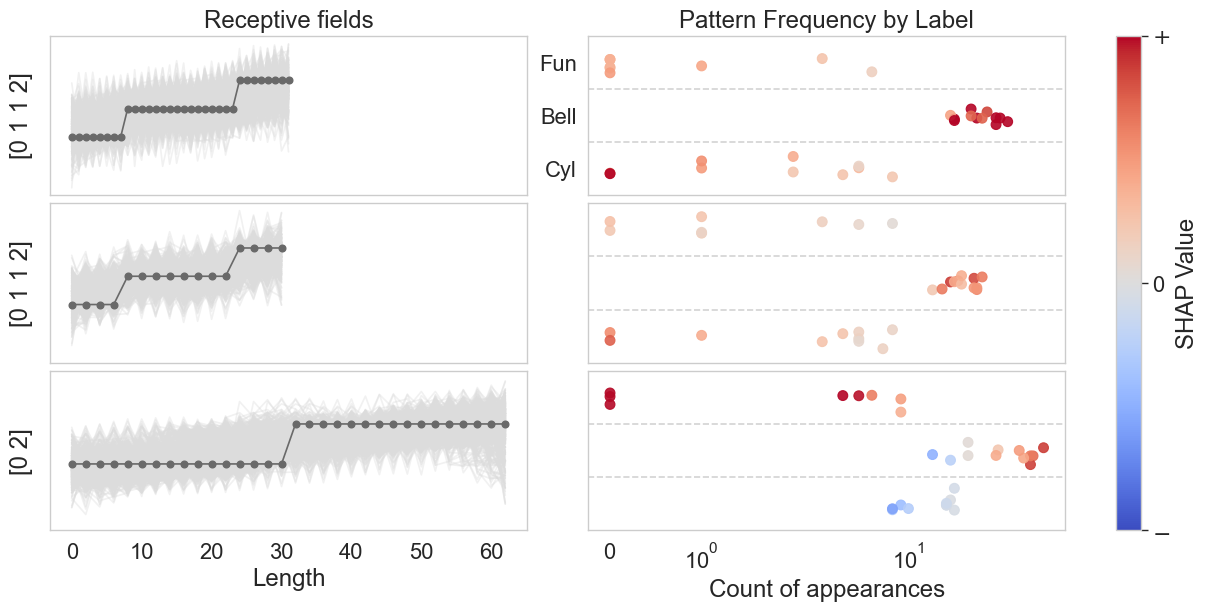

In [27]:
labels = ["Cyl", "Bell", "Fun"]
def rand_jitter(arr, jitter_multiplier=0.05):
    stdev = jitter_multiplier * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, ax=None, jitter_x=True, jitter_y=True, jitter_multiplier=0.05, **kwargs):
    if ax is None:
        ax = plt.gca()
    if jitter_x:
        x = rand_jitter(x, jitter_multiplier)
    if jitter_y:
        y = rand_jitter(y, jitter_multiplier)
    return ax.scatter(x, y, **kwargs)

sns.set_context("paper", font_scale=1.8)
n_patterns = 3
fig, axs = plt.subplots(n_patterns, 2, figsize=(12, n_patterns*2), width_ratios=[1, 1], sharex="col", sharey="col", squeeze=False, layout="constrained")

for a, j in enumerate(mapper.F_avg_rank_argsort_[:n_patterns]):
    colors = []
    for i in range(len(mapper.y_pred_)):
        all_values = mapper.F_[i]
        cmap = plt.get_cmap('coolwarm')
        norm = CenteredNorm()
        norm(all_values)
        colors.append(cmap(norm(mapper.F_[i, j])))
    rfield = mapper.receptive_fields_[j]
    rfields = np.vstack(rfield.mappings)
    rfields = rfields.reshape(rfields.shape[0], -1)
    rfields_idx = np.arange(0, rfield.window_size*rfield.dilation, rfield.dilation)
    rfields_mean = rfields.mean(axis=1)
    rfields_std = rfields.std(axis=1)
    rfields_norm = (rfields - rfields_mean[:, np.newaxis]) / (rfields_std[:, np.newaxis] + 1e-6)
    word_array_norm = (rfield.word_array - rfield.word_array.mean()) / (rfield.word_array.std() + 1e-6)
    axs[a, 0].plot(rfields_idx, np.repeat(word_array_norm, rfield.window_size//rfield.word_length), marker='o', c='dimgray')
    axs[a, 0].plot(rfields_idx, rfields_norm.T, c='gainsboro', alpha=0.4, zorder=0)
    axs[a, 0].set_ylabel(str(rfield.word_array))
    axs[a, 0].set_yticklabels([])
    axs[a, 0].grid(False)
    axs[a, 1].grid(False)
    axs[a, 0].tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False) # labels along the bottom edge are off
    
    if a == 0:
        axs[a, 0].set_title("Receptive fields")
        axs[a, 1].set_title("Pattern Frequency by Label")
        axs[a, 1].set_yticks(np.arange(len(labels)))
        axs[a, 1].set_yticklabels(labels)
    else:
        axs[a, 1].set_yticks(np.arange(len(labels)))
        for label in axs[a, 1].get_yticklabels():
            label.set_alpha(0)
    if a == n_patterns - 1:
        axs[a, 1].set_xlabel("Count of appearances")
        axs[a, 0].set_xlabel("Length")
    jitter(x=mapper.X_transformed_[:, j].toarray().ravel(), y=mapper.y_pred_, ax=axs[a, 1], c=colors, alpha=0.9, jitter_x=False, jitter_multiplier=0.05, s=50)
    axs[a, 1].set_xscale('symlog')
    for b in range(np.unique(mapper.y_pred_).shape[0]-1):
        axs[a, 1].axhline(0.5 + b, c='lightgray', linestyle='--')
    axs[a, 1].set_ylim(-0.5, np.unique(mapper.y_pred_).shape[0]-0.5)

norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cmap = plt.get_cmap('coolwarm')
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
cbar = fig.colorbar(sm, ax=axs)
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels([r'$-$', '0', r'$+$'])
cbar.set_label("SHAP Value")
plt.show()